<h1>Simple ABC</h1>

Now let's take a look at producing a refined posterior parameter range from which more sophisticated calibration technics could use as the foundation. 

If you would like to use this as a starting point for your own calibration please feel free. We will provide a list of possible improvements at the end to get you started.

Please note that this code is heavily inspired by the following [repo](https://github.com/rcmorehead/simpleabc), go check it out :)

In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')

import numpy as np 
import pandas as pd
from pandas import Series, DataFrame, Panel
from scipy import stats
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn.utils import resample
from scipy.stats import skew, kurtosis

from samplers.centered_lhs import LhsCenter
from models.brock_and_hommes import brock_and_hommes
from calibration_tools.aprox_bayesian_comp import simple_abc
from tqdm import tqdm_notebook
import seaborn as sns
sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>Target data</h2>
Before doing any analysis we will need to define the target data for which we will calibrate to. If you take a look in the data folder you will see the 'returns_data.csv' file. This is a single column of 252 entries. Each entry gives the percentage returns from the previous entry. Let's take a look.

In [38]:
market_returns_data = np.loadtxt('../data/returns_data.csv')

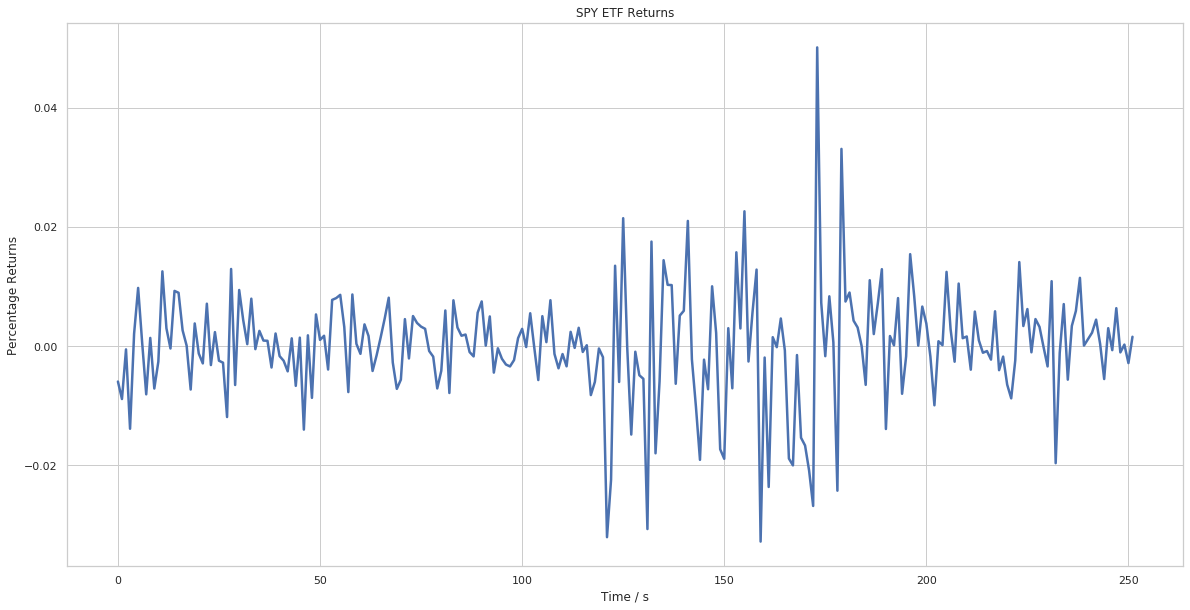

In [39]:
plt.subplots(figsize=[20, 10])
plt.title('SPY ETF Returns')
plt.xlabel('Time / s')
plt.ylabel('Percentage Returns')
sns.lineplot(data=market_returns_data, linewidth=2.5)

<h2>Bootstapped moments</h2>
<p>We will use the moments of this data to calculate a suitable posterior parameter distribution for the Brock and Hommes model by comparing them to our synthetic data run by run. Let's start by calculating the first four target moments</p>

In [40]:
bootstaped_returns = []
for i in range(10000):
    np.random.seed(i)
    bootstaped_returns.append((resample(market_returns_data)))

In [41]:
bootstrap_mean = np.mean(bootstaped_returns, axis=1)
bootstrap_std = np.std(bootstaped_returns, axis=1)
bootstrap_skew = skew(bootstaped_returns)
bootstrap_kurt = kurtosis(bootstaped_returns)

lower_bound_mean = np.percentile(bootstrap_mean, 1)
upper_bound_mean = np.percentile(bootstrap_mean, 99)

lower_bound_std = np.percentile(bootstrap_std, 1)
upper_bound_std = np.percentile(bootstrap_std, 99)


lower_bound_skew = np.percentile(bootstrap_skew, 1)
upper_bound_skew = np.percentile(bootstrap_skew, 99)

lower_bound_kurt = np.percentile(bootstrap_kurt, 1)
upper_bound_kurt = np.percentile(bootstrap_kurt, 99)

Text(0.5, 1.0, 'Kurtosis')

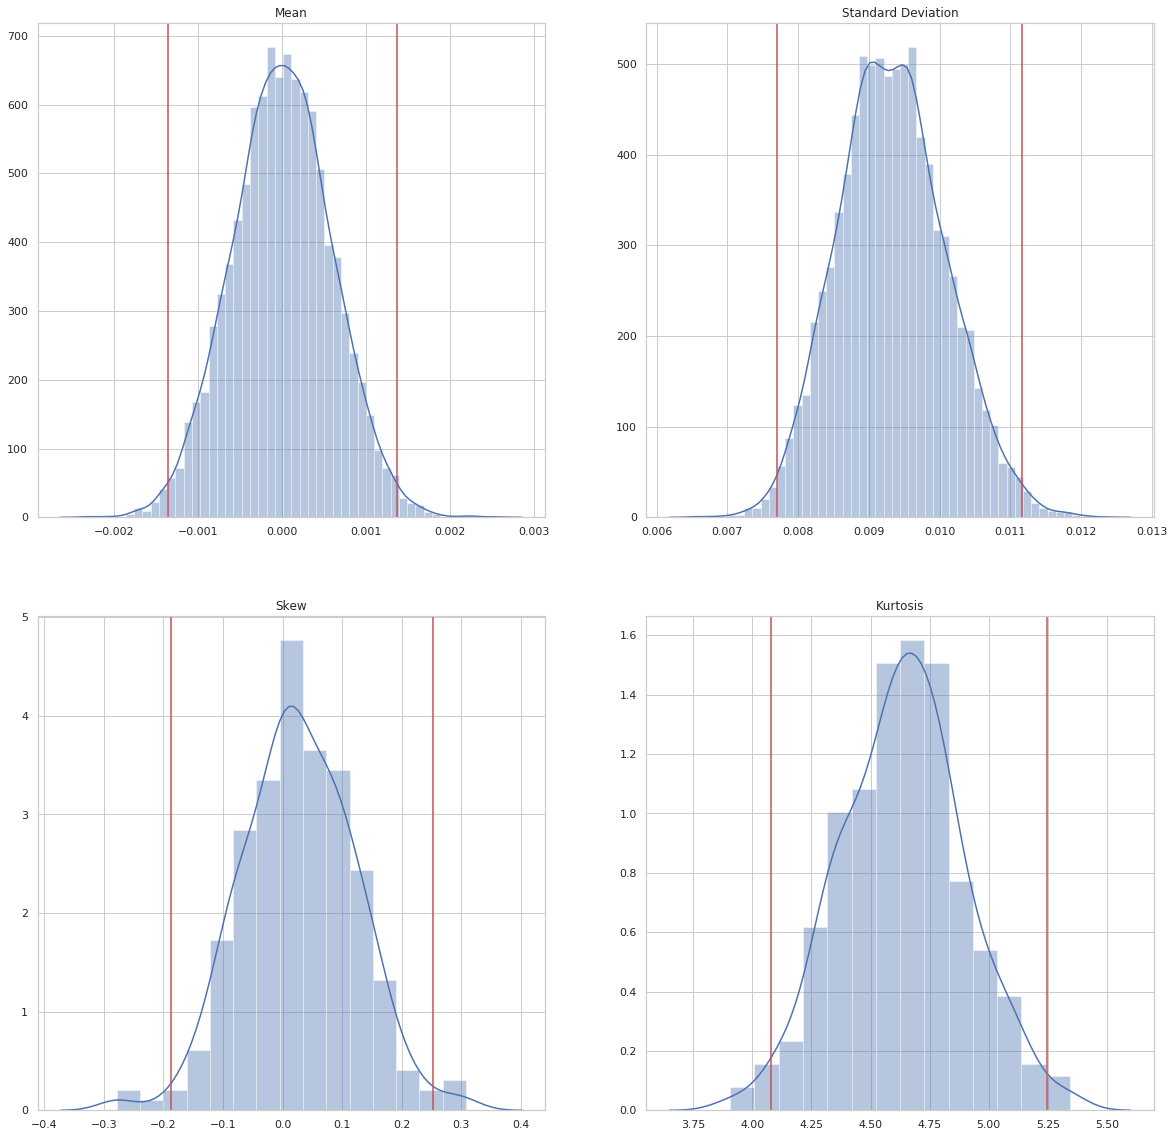

In [42]:
plt.subplots(2, 2, figsize=(20,20))

plt.subplot(2,2,1)
sns.distplot(bootstrap_mean)
plt.axvline(lower_bound_mean, color='r')
plt.axvline(upper_bound_mean, color='r')
plt.title('Mean')


plt.subplot(2,2,2)
sns.distplot(bootstrap_std)
plt.axvline(lower_bound_std, color='r')
plt.axvline(upper_bound_std, color='r')
plt.title('Standard Deviation')


plt.subplot(2,2,3)
sns.distplot(bootstrap_skew)
plt.axvline(lower_bound_skew, color='r')
plt.axvline(upper_bound_skew, color='r')
plt.title('Skew')


plt.subplot(2,2,4)
sns.distplot(bootstrap_kurt)
plt.axvline(lower_bound_kurt, color='r')
plt.axvline(upper_bound_kurt, color='r')
plt.title('Kurtosis')

<h2>Setting up the problem</h2>
<p>Let's now run a simple accept/reject for our parameters. We will us the simple_abc module first defining our Model class.</p>

In [43]:
class BrockAndHommesABC(simple_abc.Model):
    
    
    def __init__(self, model_run_df, count=0):
        self.model_run_df = model_run_df
        self.total_samples = len(model_run_df)
        self.count = count
        
 
    def draw_theta(self):
        if(self.count > self.total_samples-1):
            raise Exception("Exhasted parameter vectors. Provide more samples, reduce the number of min_samples or lower epsilon.")
            print(self.model_run_df['params'].iloc[self.count])
        return self.model_run_df['params'].iloc[self.count]

    def generate_data(self, theta):
        data = self.model_run_df['percentage_change'].iloc[self.count]
        self.count = self.count + 1
        return data
        
        
    def summary_stats(self, data):
        """
        :param data: synthetic data generated by the model
        :return: the mean of the data
        """
        x_bar = np.mean(data[1:])
        var = np.var(data[1:])
        skew = stats.skew(data[1:])
        kurtosis = stats.kurtosis(data[1:])
        return (x_bar, var, skew, kurtosis)

        # And finally the distance function. We are just going to use the euclidean distance
        # from our observed summary stats

    def distance_function(self, summary_stats, synth_summary_stats):
        x, v, s, k = summary_stats
        x_s, v_s, s_s, k_s = synth_summary_stats
        loss = 0.25* ((x-x_s)**2 + (v-v_s)**2 + (s - s_s)**2 + (k - k_s)**2)
        return loss

In [44]:
# Read in the parquet data
returns_df = pd.read_parquet('../data/synthetic_data')

In [45]:
# Only interested in the finished runs
finished_runs_df = returns_df[returns_df['has_finished'] == True]

# Set a random seed
np.random.seed(914)

# Initialize our model object
model = BrockAndHommesABC(finished_runs_df)


# pass the data to the model
model.set_data(market_returns_data)

<h2>Calculating the posterior distribution</h2>
The basic abc method looks through all of our synthetic time series. It compares the average of the first four moments to that of our target data.

In [46]:
(posterior, distances, accepted_count, trial_count,
 epsilon, weights, tau_squared, eff_sample, synth_data) = simple_abc.basic_abc(model, market_returns_data, min_samples=100, epsilon=1000)

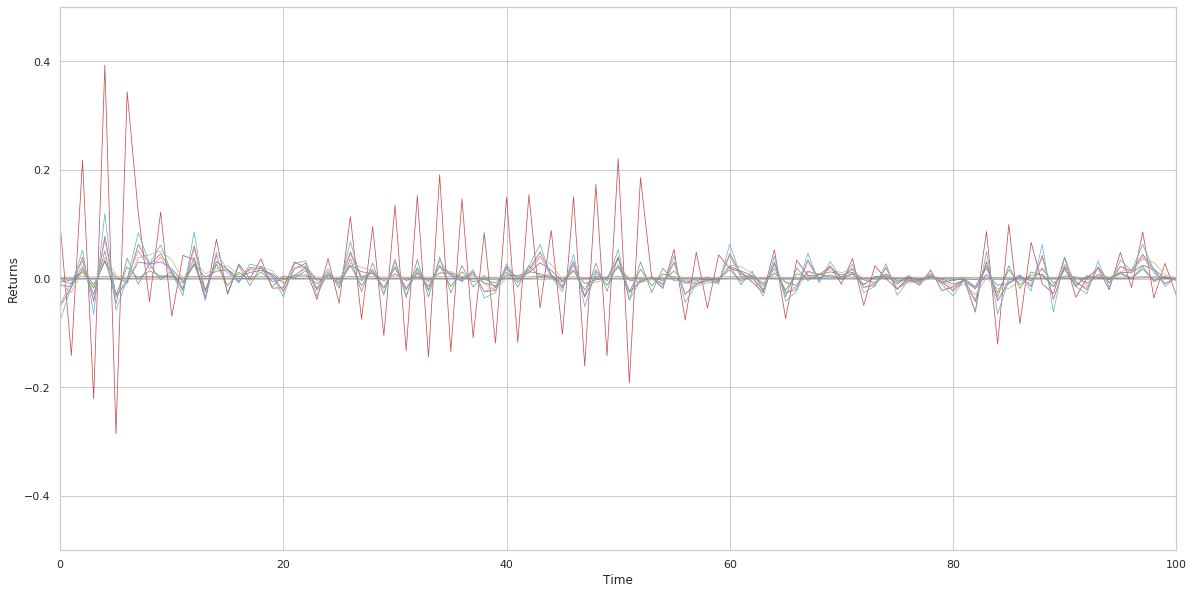

In [47]:
plt.subplots(figsize=[20, 10])
for time_series in synth_data[:10]:
    sns.lineplot(data=time_series[1:], linewidth=0.75)
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.ylim(-0.5, 0.5)
    plt.xlim(0, 100)

<h2>Much better...</h2>
Now let's take a look at the posterior distributions

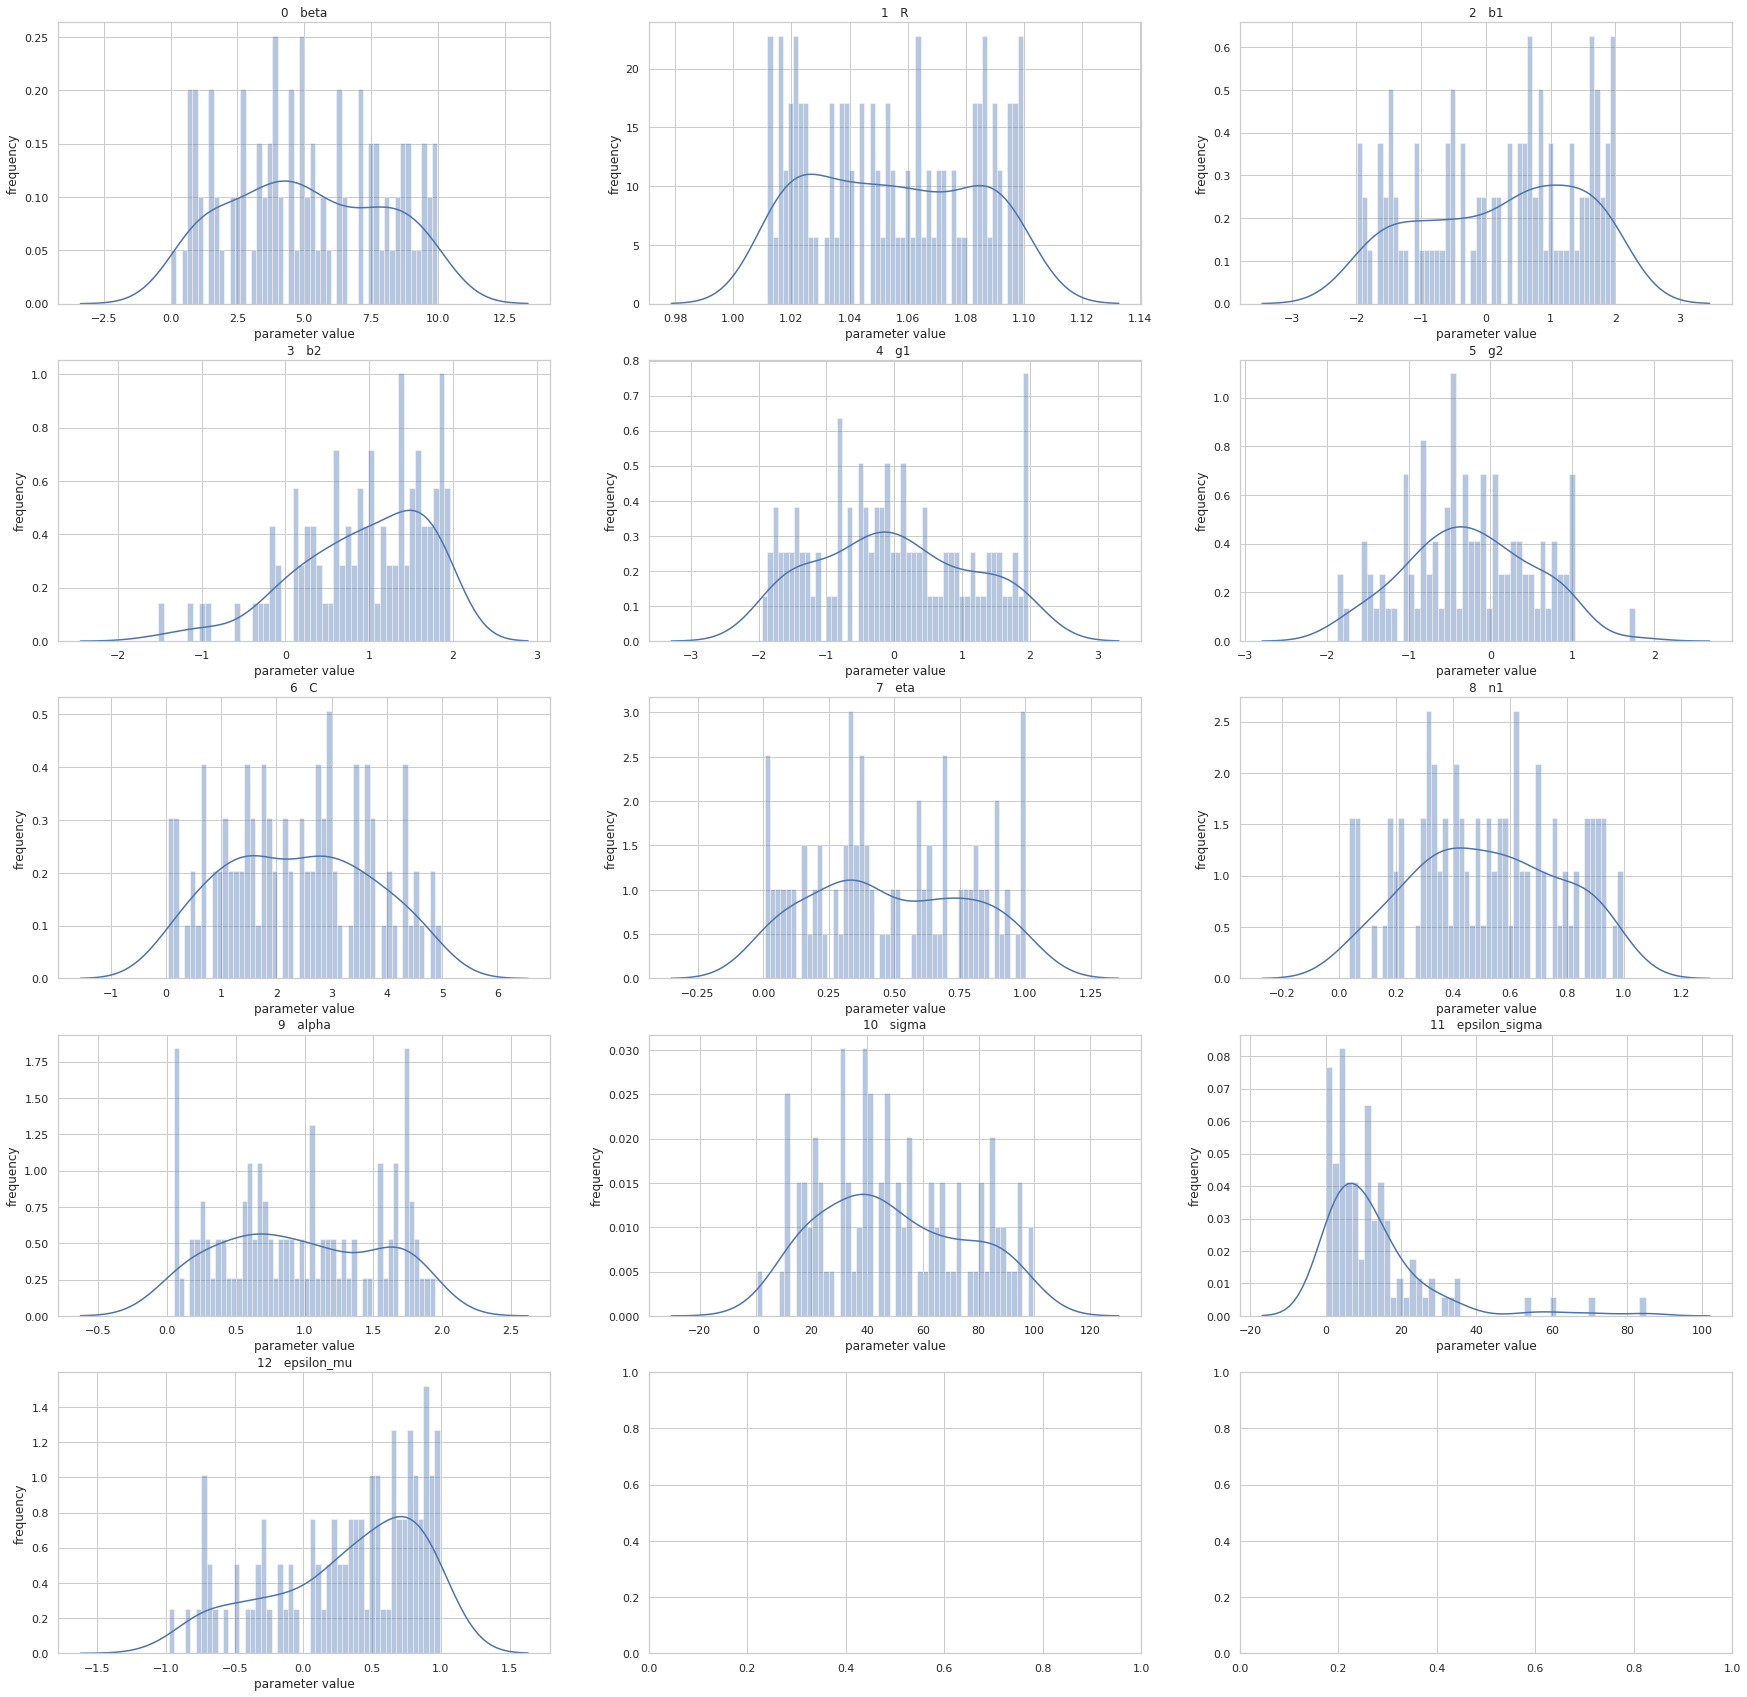

In [48]:
calibration_params =  ['beta',  'R', 'b1', 'b2', 'g1 ', 'g2', 'C', 'eta', 'n1', 'alpha', 'sigma', 'epsilon_sigma', 'epsilon_mu']
                      
posterior_df = pd.DataFrame(posterior)
fig,ax = plt.subplots(5, 3, figsize=(30,30))
for i in range(13):
    plt.subplot(5,3,i+1)
    sns.distplot(posterior_df.iloc[i], bins=50)
    plt.title('{}   {}'.format(i, calibration_params[i]))
    plt.ylabel('frequency')
    plt.xlabel('parameter value')

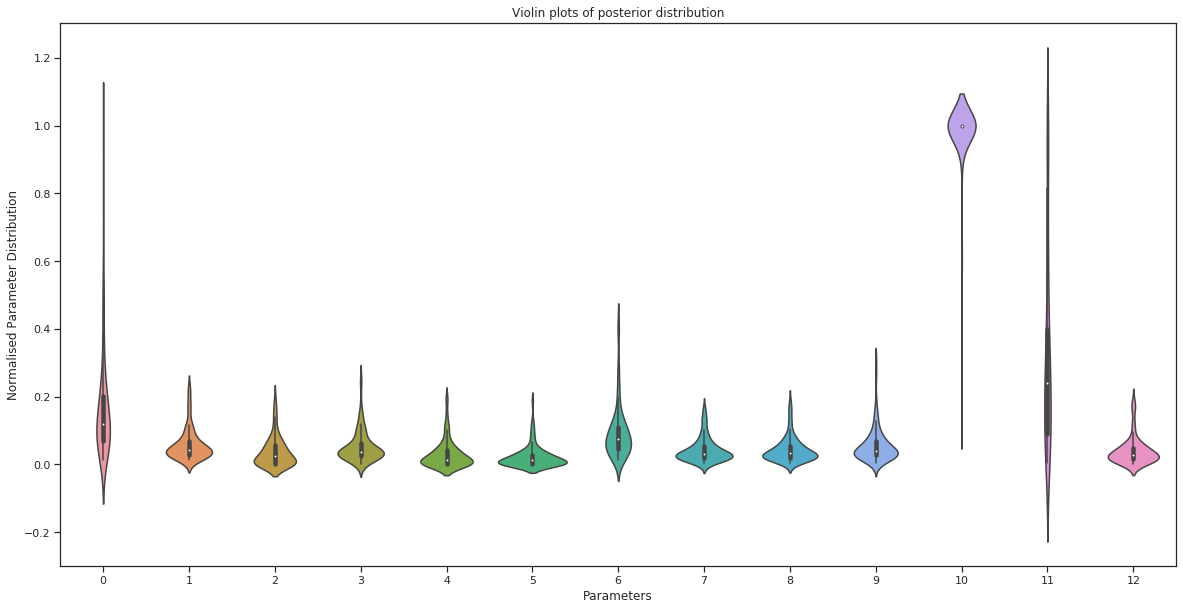

In [49]:
sns.set_style('ticks')
# the size of A4 paper
plt.subplots(figsize=[20, 10])
plt.xlabel('Parameters')
plt.ylabel('Normalised Parameter Distribution')
plt.title('Violin plots of posterior distribution')
sns.violinplot(data=df.T)

<h2>Suggested next steps...</h2>
<p>If you are looking for a method to implement take a look at the following. There are stubbed out methods inside simple_abc coresponding to these methods you can implement :).</p>

* Pseudo Marginal ABC Sampler
* Synthetic Likelihood ABC
* Adaptive Synthetic Likelihood ABC
* KDE Likelihood ABC
* Adaptive KDE Likelihood ABC
* Projected Synthetic Surrogate ABC
* Projected KDE Surrogate ABC

Take a look at this [repo](https://github.com/Neojume/pythonABC) to check out some implementations.